<a href="https://colab.research.google.com/github/AllanKamimura/Pai_ta_ON_python/blob/main/school/SEM0579_aeroelasticity_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title #imports
!git clone http://github.com/AllanKamimura/utils.git
!pip install -q ambiance
!mkdir ./runs

import sympy as sp
import requests as req
from ambiance import Atmosphere
from utils.myutils import *
from IPython.display import display, Math, Latex, Markdown

Cloning into 'utils'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 1), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (6/6), 1.66 KiB | 1.66 MiB/s, done.


In [ ]:
#@title #Questão 1 { run: "auto" }
#@markdown ##considerei $C_{L_\alpha} = 2 \pi$ para todos os aerofolios
#@markdown de a) para b), percebemos que a tendência de se jogar o CG da asa para trás é aumentar o $k_{\theta}$ necessario

#@markdown enquanto que de b) para c) o efeito de se jogar o EE para frente é diminuir drasticamente o $k_{\theta}$ necessario, o que faz sentido, visto que ao se aproximar do CA, diminui-se o braço gerado pelo lift e consequentemente a torsão gerada pelo carregamento aerodinamico

#params dictonary
AIRFOIL_DATA = {
    "naca 0012" : {"H"      : 0,
                   "U_oo"   : 30,
                   "chord"  : 1.2,
                   "ALPHA_0": 3,
                   "THETA"  : 5,
                   "CMca"   : 0,
                   "CL0"    : 0,
                   "mu"     : 6},
    "naca 63210": {"H"      : 0,
                   "U_oo"   : 30,
                   "chord"  : 1.2,
                   "ALPHA_0": 3,
                   "THETA"  : 5,
                   "CMca"   : -0.0395,
                   "CL0"    : 0.1758,
                   "mu"     : 10},
    "epler 423" : {"H"      : 0,
                   "U_oo"   : 30,
                   "chord"  : 1.2,
                   "ALPHA_0": 3,
                   "THETA"  : 5,
                   "CMca"   : -0.1719,
                   "CL0"    : 1.0957,
                   "mu"     : 1}
}

GEOMETRIC_FEATURES = {
    "a":{
        "X0"     : 0.65,
        "XCG"    : 0.45,
        "XCA"    : 0.25,
        "AREA"   : 1
        },
    "b":{
        "X0"     : 0.65,
        "XCG"    : 0.65,
        "XCA"    : 0.25,
        "AREA"   : 1
        },
    "c":{
        "X0"     : 0.45,
        "XCG"    : 0.65,
        "XCA"    : 0.25,
        "AREA"   : 1
        }
}

#define symbolic variables
W = sp.Symbol("W")

mu  = sp.Symbol("mu")
xca = sp.Symbol("x_{ca}")
xcg = sp.Symbol("x_{cg}")
x0  = sp.Symbol("x_{0}")

c  = sp.Symbol("c")
e  = sp.Symbol("e")
e0 = sp.Symbol("e_0")
S  = sp.Symbol("S")

CMca = sp.Symbol("C_{M_{ca}}")
CL0  = sp.Symbol("C_{L_{0}}")
CLa  = sp.Symbol("C_{L_{\\alpha}}")
a0   = sp.Symbol("\\alpha_0")

q   = sp.Symbol("q")
rho = sp.Symbol("\\rho")
U   = sp.Symbol("U")

kt  = sp.Symbol("k_{\\theta}")
theta = sp.Symbol("\\theta")

display(Markdown("#Solve Divergence"))
print()

#solve divergence equation for kt
exp1 = sp.Eq(theta, (q * S * (c * CMca + e * CL0 + e * CLa * a0) - W * e0) / (kt - q * S * e * CLa))
display(exp1)
print()

x = kt
exp2 = sp.solve(exp1, x)[0]
display(sp.Eq(kt, exp2))
print()

for airfoil in AIRFOIL_DATA.keys():
    display(Markdown(f"## {airfoil}"))
    for case_number in GEOMETRIC_FEATURES.keys():

        #load params
        H       = AIRFOIL_DATA[airfoil]["H"]
        U_oo    = AIRFOIL_DATA[airfoil]["U_oo"]

        chord   = AIRFOIL_DATA[airfoil]["chord"]
        ALPHA_0 = AIRFOIL_DATA[airfoil]["ALPHA_0"]
        THETA   = AIRFOIL_DATA[airfoil]["THETA"]

        X0   = GEOMETRIC_FEATURES[case_number]["X0"]
        XCG  = GEOMETRIC_FEATURES[case_number]["XCG"]
        XCA  = GEOMETRIC_FEATURES[case_number]["XCA"]
        AREA = GEOMETRIC_FEATURES[case_number]["AREA"]

        display(Latex(f"\\qquad {case_number}) \quad {x0} = {X0}c \quad {xcg} = {XCG}c \quad {xca} = {XCA}c \quad"))
        print()
        alpha = ALPHA_0 + THETA
        sealevel = Atmosphere(H)

        #subs
        basic_vars = {
            e   : x0 - xca,
            e0  : x0 - xcg,
            S   : AREA,
            q   : rho * U ** 2 / 2,
            rho : float(sealevel.density),
            W   : mu * c * float(sealevel.grav_accel),
        }

        y = exp2
        for key, value in basic_vars.items():
            y = y.subs(key, value)

        vars = {
            CLa  : 2 * sp.pi,
            CMca : AIRFOIL_DATA[airfoil]["CMca"],
            CL0  : AIRFOIL_DATA[airfoil]["CL0"],
            mu   : AIRFOIL_DATA[airfoil]["mu"],
            U    : U_oo,
            x0   : X0  * c,
            xcg  : XCG * c,
            xca  : XCA * c,
            c    : chord,
            a0   : np.deg2rad(ALPHA_0),
            theta: np.deg2rad(THETA),
        }

        for key, value in vars.items():
            y = y.subs(key, value)

        display(Latex(f"\\qquad\\qquad {kt} = {y.evalf():.3f} \\ N \\cdot m /rad"))
        print()
        # display(Markdown(" 12"), sp.Eq(kt, y.evalf()))

#Solve Divergence

Eq(\theta, (S*q*(C_{L_{0}}*e + C_{L_{\alpha}}*\alpha_0*e + C_{M_{ca}}*c) - W*e_0)/(-C_{L_{\alpha}}*S*e*q + k_{\theta}))

Eq(k_{\theta}, (C_{L_{0}}*S*e*q + C_{L_{\alpha}}*S*\alpha_0*e*q + C_{L_{\alpha}}*S*\theta*e*q + C_{M_{ca}}*S*c*q - W*e_0)/\theta)

## naca 0012

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## naca 63210

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## epler 423

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#Solve Divergence

Eq(\theta, (S*q*(C_{L_{0}}*e + C_{L_{\alpha}}*\alpha_0*e + C_{M_{ca}}*c) - W*e_0)/(-C_{L_{\alpha}}*S*e*q + k_{\theta}))

Eq(C_{L_{\alpha}}*S*e*q, 230.907063455198)

## naca 0012

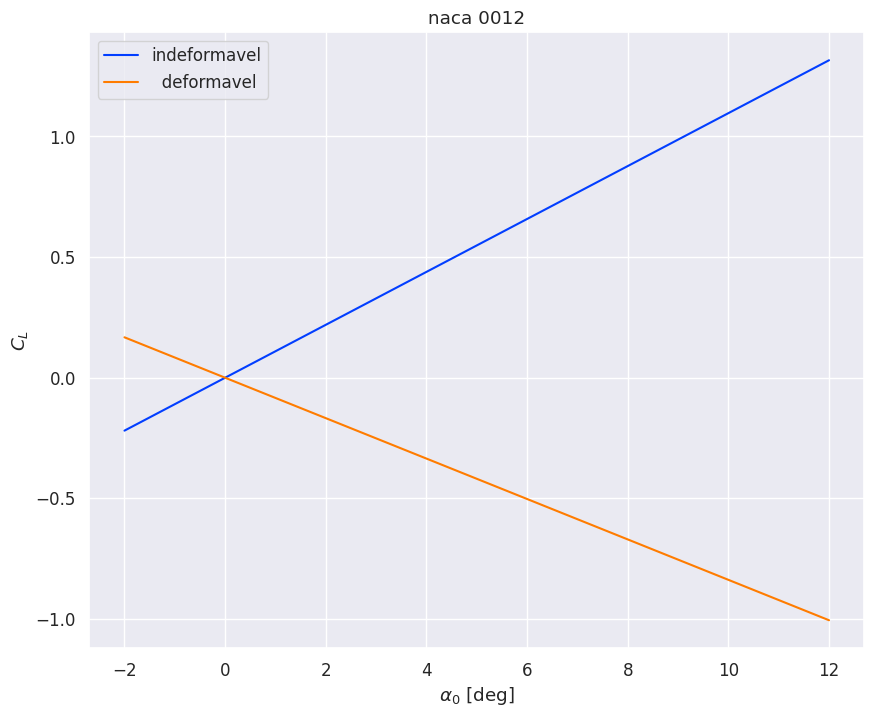

## naca 63210

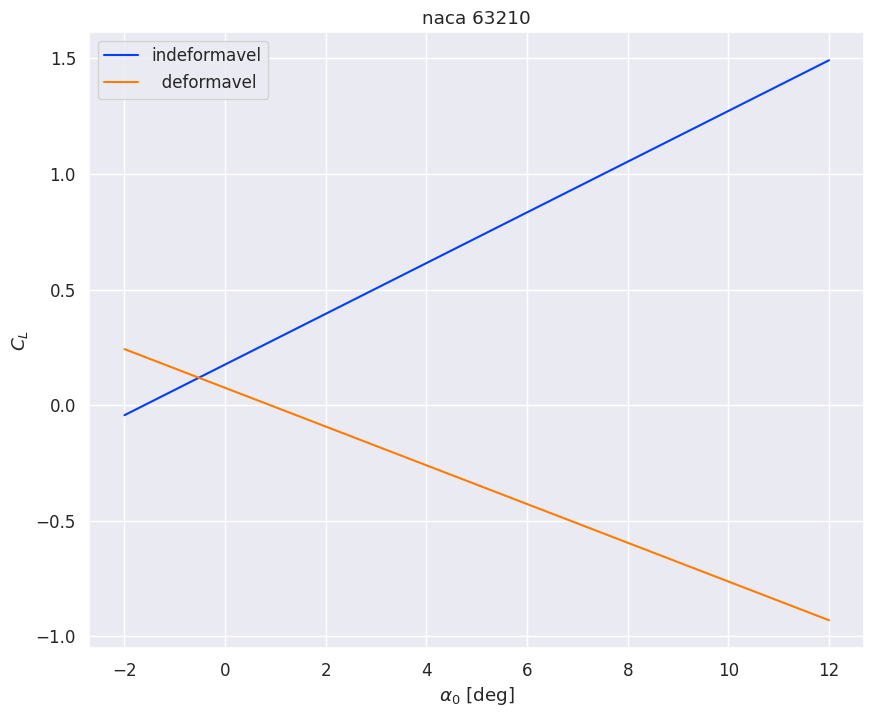

In [ ]:
#@title #Questão 2 { run: "auto", form-width: "20px" }
#@markdown ##considerei $C_{L_\alpha} = 2 \pi$ para todos os aerofolios
#@markdown Como a "rididez aerodinamica" é maior do que a rigidez estrutural, o termo no denominador da expressão de $\theta$  fica negativo

#params dictonary
AIRFOIL_DATA = {
    "naca 0012" : {"H"      : 0,
                   "U_oo"   : 20,
                   "chord"  : 0.45,
                   "ALPHA_0": 0,
                   "CMca"   : 0,
                   "CL0"    : 0},
    "naca 63210": {"H"      : 0,
                   "U_oo"   : 20,
                   "chord"  : 0.45,
                   "ALPHA_0": 0,
                   "CMca"   : -0.0395,
                   "CL0"    : 0.1758},
}

GEOMETRIC_FEATURES = {
    "a":{
        "X0"     : 0.45,
        "XCG"    : 0.45,
        "XCA"    : 0.30,
        "AREA"   : 1,
        "kt"     : 100,
        },
}

#define symbolic variables
W = sp.Symbol("W")

xca = sp.Symbol("x_{ca}")
xcg = sp.Symbol("x_{cg}")
x0  = sp.Symbol("x_{0}")

c  = sp.Symbol("c")
e  = sp.Symbol("e")
e0 = sp.Symbol("e_0")
S  = sp.Symbol("S")

CMca = sp.Symbol("C_{M_{ca}}")
CL0  = sp.Symbol("C_{L_{0}}")
CLa  = sp.Symbol("C_{L_{\\alpha}}")
a0   = sp.Symbol("\\alpha_0")

q   = sp.Symbol("q")
rho = sp.Symbol("\\rho")
U   = sp.Symbol("U")

kt  = sp.Symbol("k_{\\theta}")
theta = sp.Symbol("\\theta")

display(Markdown("#Solve Divergence"))
print()

#solve divergence equation for kt
exp1 = sp.Eq(theta, (q * S * (c * CMca + e * CL0 + e * CLa * a0) - W * e0) / (kt - q * S * e * CLa))
display(exp1)
print()

exp2 = sp.Eq(q * S * e * CLa, (q * S * e * 2*sp.pi).subs({"S": 1, "e": 0.15, "q": float(sealevel.density) * 200}).evalf())
display(exp2)
print()

for airfoil in AIRFOIL_DATA.keys():
    display(Markdown(f"## {airfoil}"))
    for case_number in GEOMETRIC_FEATURES.keys():

        #load params
        H       = AIRFOIL_DATA[airfoil]["H"]
        U_oo    = AIRFOIL_DATA[airfoil]["U_oo"]

        chord   = AIRFOIL_DATA[airfoil]["chord"]
        ALPHA_0 = AIRFOIL_DATA[airfoil]["ALPHA_0"]

        X0   = GEOMETRIC_FEATURES[case_number]["X0"]
        XCG  = GEOMETRIC_FEATURES[case_number]["XCG"]
        XCA  = GEOMETRIC_FEATURES[case_number]["XCA"]
        AREA = GEOMETRIC_FEATURES[case_number]["AREA"]
        KT   = GEOMETRIC_FEATURES[case_number]["kt"]

        alpha = ALPHA_0 + THETA
        sealevel = Atmosphere(H)

        #subs
        basic_vars = {
            e   : x0 - xca,
            e0  : x0 - xcg,
            S   : AREA,
            q   : rho * U_oo ** 2 / 2,
            rho : float(sealevel.density)
        }

        y = exp1.rhs
        for key, value in basic_vars.items():
            y = y.subs(key, value)

        vars = {
            CLa  : 2 * sp.pi,
            CMca : AIRFOIL_DATA[airfoil]["CMca"],
            CL0  : AIRFOIL_DATA[airfoil]["CL0"],
            W    : 6 * c * float(sealevel.grav_accel),
            U    : U_oo,
            x0   : X0 ,
            xcg  : XCG,
            xca  : XCA,
            c    : chord,
            # a0   : np.deg2rad(ALPHA_0),
            kt   : KT,
        }

        for key, value in vars.items():
            y = y.subs(key, value)
        fun = sp.lambdify(a0, y)

        a0_range = np.deg2rad(np.linspace(-2, 12, 100))
        CL_indef = AIRFOIL_DATA[airfoil]["CL0"] + 2 * np.pi * (a0_range)
        CL_def   = AIRFOIL_DATA[airfoil]["CL0"] + 2 * np.pi * (a0_range + fun(a0_range))

        plt.plot(np.rad2deg(a0_range), CL_indef, label = "indeformavel")
        plt.plot(np.rad2deg(a0_range), CL_def  , label = "  deformavel")
        plt.legend()
        plt.ylabel("$C_L$")
        plt.xlabel("$\\alpha_0$ [deg]")
        plt.title(airfoil)
        plt.show()

# Questão 3

Como o aerofólio é rigido a torsão, existirá um torque externo sendo aplicado ao aerofólio

![aerofilio](https://drive.google.com/uc?export=download&id=1kYPiKgyOpz9oD_CUvQ6xR87h_M7CY7xg&confirm=no_antivirus)


Do equilibrio de forças:
$
L \cdot \cos{\alpha_0} = k_h \cdot h + W
\\q \cdot S \cdot \cos{\alpha_0} \cdot C_{L} = k_h \cdot h + W
\\C_{L} = C_{L_0} + C_{L_\alpha} \cdot \alpha_0
\\q = \frac{k_h \cdot h + W}{(C_{L_0} + C_{L_\alpha})  \cdot S \cdot \cos{\alpha_0} }
$

Para se determinar a pressão dinamica de divergência, resolve-se para $h$

$
h = \frac{q (C_{L_0} + C_{L_\alpha})  \cdot S \cdot \cos{\alpha_0}  - W}{k_h}
$

Da onde se percebe que não há um valor de $q$ no qual o valor de $h$ é indeterminado


# Questão 4

Primeiramente, descobre-se a relação entre $\Delta h$ e $\Delta \theta$, utilizando uma aproximação para pequenos ângulos.

<img src="https://drive.google.com/uc?export=download&id=1Y1PW9u5bm5n8729i115a-XyLuijgvnOf&confirm=no_antivirus" alt= “” width="500" height="value">

As forças que agem sobre o aerofolio

<img src="https://drive.google.com/uc?export=download&id=17Pn0od37QFYrizYrI4bC6_k_dmTZ1cOW&confirm=no_antivirus" alt= “” width="500" height="value">

Como o aerofolio é simetrico, acho que precisaria de um ângulo de incidencia $\alpha_0 != 0$

Do equilibrio de momentos em torno de O (a força elastica no desenho ta para o lado errado 😶)

$
L \cdot \frac{c}{4} = k_h \cdot \Delta h \cdot \cos{\Delta \theta} \cdot \frac{c}{2}
$

Utilizando uma aproximação para pequenos ângulos, $cos{\Delta \theta} \approx 1$ e  $\Delta \theta = \alpha + \alpha_0$.

$
q \cdot S \cdot (C_{L_0} + C_{L_\alpha} \cdot (\alpha + \alpha_0)) = 2 \cdot k_h \cdot \Delta h = k_h \cdot c \cdot (\alpha + \alpha_0)
$

#Solve Divergence

Eq(\alpha, (S*q*(C_{L_{0}} + C_{L_{\alpha}}*\alpha_0) - \alpha_0*c*k_{h})/(-C_{L_{\alpha}}*S*q + c*k_{h}))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Mudando o ponto de pivotamento, por meio da variavel x e com a aproximação para pequenos angulos


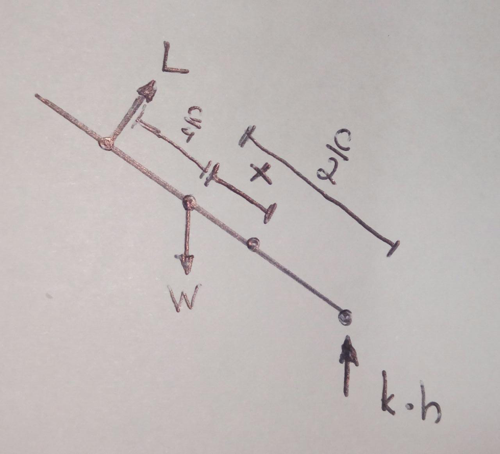

Eq(S*q*(C_{L_{0}} + C_{L_{\alpha}}*(\alpha + \alpha_0))*(c/4 + x), W*x + k_{h}*(\alpha + \alpha_0)*(c/2 - x)**2)

Eq(\alpha, (-C_{L_{0}}*S*c*q - 4*C_{L_{0}}*S*q*x - C_{L_{\alpha}}*S*\alpha_0*c*q - 4*C_{L_{\alpha}}*S*\alpha_0*q*x + 4*W*x + \alpha_0*k_{h}*(c - 2*x)**2)/(C_{L_{\alpha}}*S*c*q + 4*C_{L_{\alpha}}*S*q*x - k_{h}*(c - 2*x)**2))


Para a divergencia, resolve-se o denominador para x


Eq(x, (C_{L_{\alpha}}*S*q + c*k_{h} - sqrt(C_{L_{\alpha}}*S*q*(C_{L_{\alpha}}*S*q + 3*c*k_{h})))/(2*k_{h}))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


observamos que o aumento para os dois casos em que o CG e o EE coincidem é de -1
isso porque simplificando a expressão do alpha, percebemos que isso acontece pois o aerofolio é simetrico e a relação do alpha é da forma



<IPython.core.display.Latex object>

In [ ]:
#@title ##Solve { form-width: "20px" }
#params dictonary

#@markdown Questão B)
Q_VALUE = 146.6 #@param{"type":"number"}
alpha_0 = 0.5   #@param{"type":"number"}
#@markdown ---
#@markdown Questão C)
q_mult_c = 2    #@param{"type":"number"}
#@markdown ---
#@markdown Questão D)
q_mult_d = 2    #@param{"type":"number"}
#@markdown Questão E)
W_value     = 15    #@param{"type":"number"}


AIRFOIL_DATA = {
    "H"      : 0,
    "chord"  : 0.15,
    "ALPHA_0": np.deg2rad(alpha_0),
    "CMca"   : 0,
    "CLa"    : 2 * sp.pi,
    "CL0"    : 0
}

GEOMETRIC_FEATURES = {
    "a":{
        "X0"     : 0.5,
        "XCG"    : 0.5,
        "XCA"    : 0.25,
        "AREA"   : 0.15 * 0.9,
        "kh"     : 4000,
        "W"      : W_value
        },
}

#define symbolic variables
W = sp.Symbol("W")

xca = sp.Symbol("x_{ca}")
xcg = sp.Symbol("x_{cg}")
x0  = sp.Symbol("x_{0}")
x  = sp.Symbol("x")

c  = sp.Symbol("c")
e  = sp.Symbol("e")
e0 = sp.Symbol("e_0")
S  = sp.Symbol("S")

CMca = sp.Symbol("C_{M_{ca}}")
CL0  = sp.Symbol("C_{L_{0}}")
CLa  = sp.Symbol("C_{L_{\\alpha}}")
a0   = sp.Symbol("\\alpha_0")
a   = sp.Symbol("\\alpha")

q   = sp.Symbol("q")
rho = sp.Symbol("\\rho")
U   = sp.Symbol("U", positive = True)

kh  = sp.Symbol("k_{h}")

display(Markdown("#Solve Divergence"))
print()

#solve divergence equation for kh
exp1 = sp.Eq(a, (q * S * (CL0 + CLa*a0) - kh * c * a0) / (-q * S * CLa + kh * c))
exp2 = (q * S * CLa - kh * c)
display(exp1)
print()

#### item a,b,c
for case_number in GEOMETRIC_FEATURES.keys():

    #load params
    H       = AIRFOIL_DATA["H"]

    chord   = AIRFOIL_DATA["chord"]
    ALPHA_0 = AIRFOIL_DATA["ALPHA_0"]

    X0      = GEOMETRIC_FEATURES[case_number]["X0"]
    XCG     = GEOMETRIC_FEATURES[case_number]["XCG"]
    XCA     = GEOMETRIC_FEATURES[case_number]["XCA"]
    AREA    = GEOMETRIC_FEATURES[case_number]["AREA"]
    KH      = GEOMETRIC_FEATURES[case_number]["kh"]
    W_VALUE = GEOMETRIC_FEATURES[case_number]["W"]

    sealevel = Atmosphere(H)

    #subs
    basic_vars = {
        e   : x0 - xca,
        e0  : x0 - xcg,
        S   : AREA,
        q   : rho * U ** 2 / 2,
        rho : float(sealevel.density),
    }

    y = exp2
    for key, value in basic_vars.items():
        y = y.subs(key, value)

    vars = {
        CLa  : 2 * sp.pi,
        CMca : AIRFOIL_DATA["CMca"],
        CL0  : AIRFOIL_DATA["CL0"],
        x0   : X0  * c,
        xcg  : XCG * c,
        xca  : XCA * c,
        c    : chord,
        a0   : np.deg2rad(ALPHA_0),
        kh   : KH,
        W    : W_VALUE
    }

    for key, value in vars.items():
        y = y.subs(key, value)

    U_value = sp.solve(y, U)[0]
    q_value = float(sealevel.density) * U_value ** 2 / 2

    display(Latex(f"\\qquad a) \quad {q} = {q_value:.3f} Pa \quad {U} = {U_value:.3f} m/s"))

    y = exp1
    for key, value in basic_vars.items():
        y = y.subs(key, value)
    for key, value in vars.items():
        y = y.subs(key, value)

    U_b = (2 * Q_VALUE / float(sealevel.density)) ** 0.5
    alpha_b = y.subs(U, U_b)

    letra_b = CLa * alpha_b.rhs / (CL0 + CLa * a0)
    letra_b = letra_b.subs(basic_vars)
    letra_b = letra_b.subs(vars)

    display(Latex(f"\\qquad b) \\quad aumento = {letra_b.evalf():.3f}"))
    display(Latex(f"\\qquad c) \\quad k_h = {q_mult_c * KH:.3f} \\;" + "\\text{N/m}") )

######### item d
print()
display(Latex(f"\\qquad d) \\quad"))
exp3 = sp.Eq((c/4 + x) * q * S * (CL0 + CLa * (a + a0)), kh * (a + a0) * (c/2-x)**2 + W * x)
exp4 = sp.solve(exp3, a)[0]

print("Mudando o ponto de pivotamento, por meio da variavel x e com a aproximação para pequenos angulos")

url = "https://drive.google.com/file/d/199szyKvl5TuU_O5q7Y1OWFUKiau3Hk2W/view?usp=sharing"

id = re.findall("d/([\S]*)/", url)[0]

export_url = 'https://drive.google.com/uc?export=download&id={}&confirm=no_antivirus'.format(id)
image = Image.open(req.get(export_url, stream=True).raw)
image.thumbnail((500, 500))
image.show()

display(exp3)
print()
display(sp.Eq(a, exp4))

exp5 = exp4.as_numer_denom()[-1]
exp6 = sp.solve(exp5, x)[0]

print()
print("Para a divergencia, resolve-se o denominador para x")
display(sp.Eq(x, exp6))

letra_d = exp6.subs(q, q_mult_d * q_value)
letra_d = letra_d.subs(basic_vars)
letra_d = letra_d.subs(vars)

display(Latex(f"\\qquad d) \\quad x = {letra_d.evalf():.3f}" + "m"))

vars = {
    CLa  : 2 * sp.pi,
    CMca : AIRFOIL_DATA["CMca"],
    CL0  : AIRFOIL_DATA["CL0"],
    x0   : X0  * c,
    xcg  : XCG * c,
    xca  : XCA * c,
    c    : chord,
    a0   : np.deg2rad(ALPHA_0),
    kh   : q_mult_c * KH,
    W    : W_VALUE
}

#### item e

basic_vars = {
    e   : x0 - xca,
    e0  : x0 - xcg,
    S   : AREA,
}

vars = {
    CLa  : 2 * sp.pi,
    CMca : AIRFOIL_DATA["CMca"],
    CL0  : AIRFOIL_DATA["CL0"],
    x0   : X0  * c,
    xcg  : XCG * c,
    xca  : XCA * c,
    c    : chord,
    a0   : np.deg2rad(ALPHA_0),
    kh   : KH * 2,
    W    : W_VALUE
}

letra_e = CLa * exp4 / (CL0 + CLa * (a0))
letra_e = letra_e.subs(basic_vars)
letra_e = letra_e.subs(vars)
letra_e = letra_e.subs(x, 0)
letra_e = letra_e.subs(q, Q_VALUE)

display(Latex(f"\\qquad e) \\quad aumento = {letra_e.evalf():.3f}"))

#### item f

basic_vars = {
    e   : x0 - xca,
    e0  : x0 - xcg,
    S   : AREA,
}

vars = {
    CLa  : 2 * sp.pi,
    CMca : AIRFOIL_DATA["CMca"],
    CL0  : AIRFOIL_DATA["CL0"],
    x0   : X0  * c,
    xcg  : XCG * c,
    xca  : XCA * c,
    c    : chord,
    a0   : np.deg2rad(ALPHA_0),
    kh   : KH,
    W    : W_VALUE
}

letra_f = CLa * exp4 / (CL0 + CLa * (a0))
letra_f = letra_f.subs(basic_vars)
letra_f = letra_f.subs(vars)
letra_f = letra_f.subs(x, letra_d)
letra_f = letra_f.subs(q, Q_VALUE)

display(Latex(f"\\qquad f) \\quad aumento = {letra_f.evalf():.3f}"))

print()
print("observamos que o aumento para os dois casos em que o CG e o EE coincidem é de -1")
print("isso porque simplificando a expressão do alpha, percebemos que isso acontece pois o aerofolio é simetrico e a relação do alpha é da forma")
print()
display(Latex("\\alpha = A \\cdot C_{L_0} - \\alpha_0"))
print()

# Questão 05

![https://drive.google.com/uc?export=download&id=1Ss2Fmt47N550s1Sa5hLjlCr6Bd1FuYr0&confirm=no_antivirus](https://drive.google.com/uc?export=download&id=1Ss2Fmt47N550s1Sa5hLjlCr6Bd1FuYr0&confirm=no_antivirus)

In [ ]:
#@title ##solve
q = sp.Symbol("q", positive = True)
S = sp.Symbol("S", positive = True)
c = sp.Symbol("c", positive = True)
CL0 = sp.Symbol("C_{L_0}", positive = True)
CLa = sp.Symbol("C_{L_\\alpha}", positive = True)
k1 = sp.Symbol("k_1", positive = True)
k2 = sp.Symbol("k_2", positive = True)
x1 = sp.Symbol("x_1", positive = True)
x2 = sp.Symbol("x_2", positive = True)
a = sp.Symbol("\\alpha")

momento   = q * S * (CL0 + CLa * a) * c/4 + k2 *c/2 * x2 - k1*c/2*x1
force     = q * S * (CL0 + CLa * a) - k1*x1 - k2*x2
geometria = c * a - x1 + x2

display(Markdown("##Force"))
display(sp.Eq(force, 0))
display(Markdown("##Momento"))
display(sp.Eq(momento, 0))
display(Markdown("##Geometria"))
display(sp.Eq(geometria, 0))

x1_value = sp.solve(geometria, x1)[0]
momento = momento.subs(x1, x1_value)
force = force.subs(x1, x1_value)

x2_value = sp.solve(momento, x2)[0]
force = force.subs(x2, x2_value)

alpha_value = sp.solve(force, a)[0]
display(Markdown("##Resolvendo para a divergencia"))
display(sp.Eq(a, alpha_value))

print()
display(Markdown("da onde se observa que o denominador é sempre maior do que zero se é valido"))
display(k1 >= 3 * k2)

##Force

Eq(S*q*(C_{L_0} + C_{L_\alpha}*\alpha) - k_1*x_1 - k_2*x_2, 0)

##Momento

Eq(S*c*q*(C_{L_0} + C_{L_\alpha}*\alpha)/4 - c*k_1*x_1/2 + c*k_2*x_2/2, 0)

##Geometria

Eq(\alpha*c - x_1 + x_2, 0)

##Resolvendo para a divergencia

Eq(\alpha, C_{L_0}*S*q*(-k_1 + 3*k_2)/(C_{L_\alpha}*S*k_1*q - 3*C_{L_\alpha}*S*k_2*q + 4*c*k_1*k_2))

da onde se observa que o denominador é sempre maior do que zero se é valido

k_1 >= 3*k_2

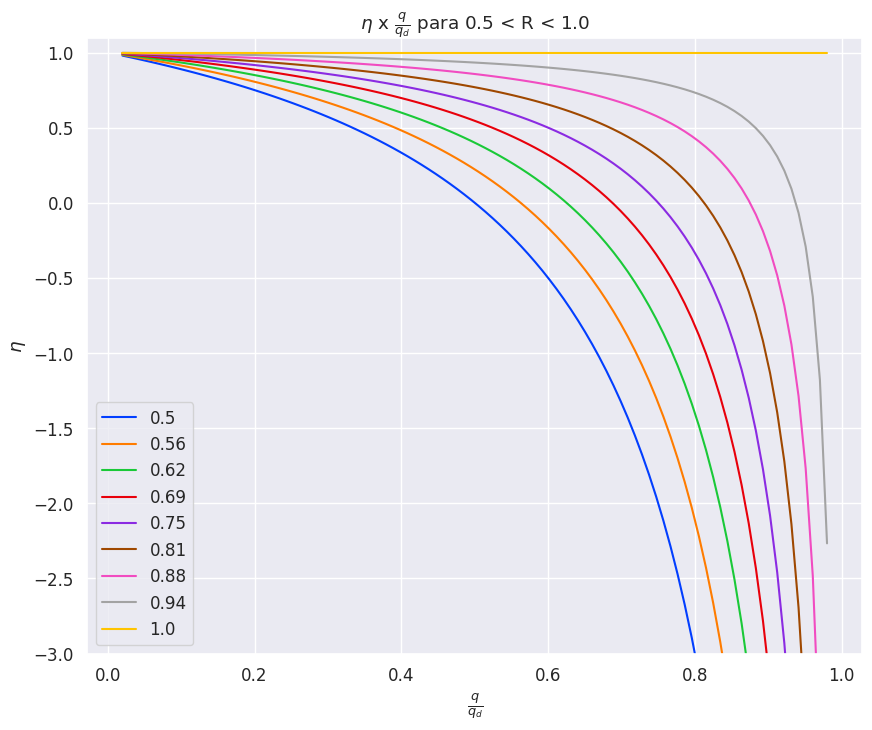

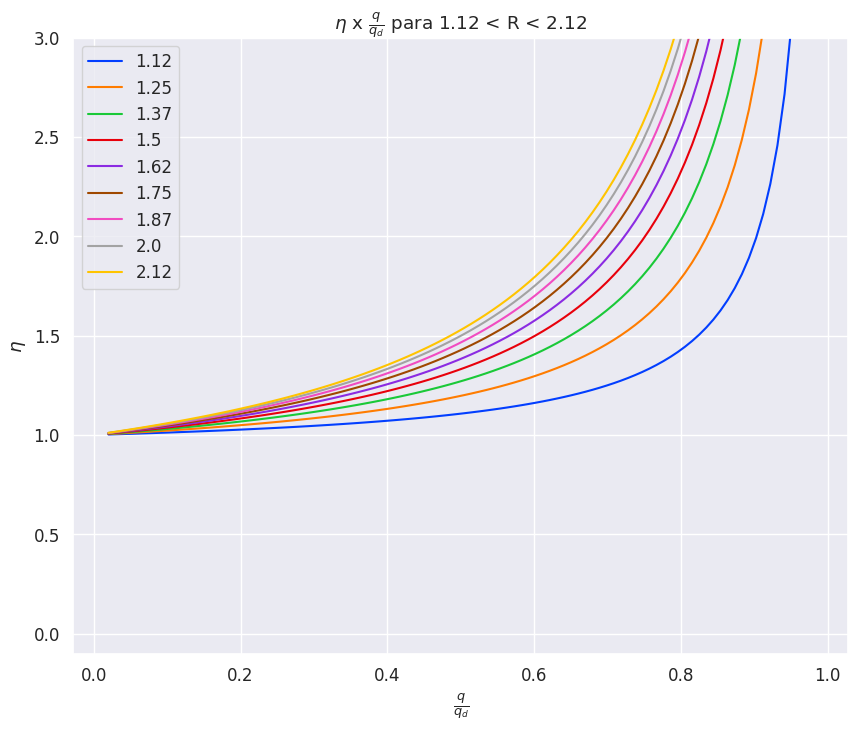

In [ ]:
#@title #Questão 06

n = 9
qqd = np.linspace(0.02, 0.98, 100)
R   = np.linspace(0.50, 1.00, n)

qqd, R = np.meshgrid(qqd, R)
qqr = qqd / R

eta = (1-qqr) / (1-qqd)

for i in range(n):
    plt.plot(qqd[i, :], eta[i, :], label = R[i, :].mean().round(2))

plt.ylabel("$\\eta$")
plt.ylim(-3, 1.1)
plt.xlabel("$\\frac{q}{q_d}$")
plt.title("$\\eta$ x $\\frac{q}{q_d}$ para 0.5 < R < 1.0")
plt.legend()
plt.show()

print()

n = 9
qqd = np.linspace(0.02, 0.98, 100)
R   = np.linspace(1.12, 2.12, n)

qqd, R = np.meshgrid(qqd, R)
qqr = qqd / R

eta = (1-qqr) / (1-qqd)

for i in range(n):
    plt.plot(qqd[i, :], eta[i, :], label = R[i, :].mean().round(2))

plt.ylabel("$\\eta$")
plt.ylim(-0.1, 3)
plt.xlabel("$\\frac{q}{q_d}$")
plt.title("$\\eta$ x $\\frac{q}{q_d}$ para 1.12 < R < 2.12")
plt.legend()
print()

In [ ]:
#@title  #Questão 07

#@markdown 1.   O reverso de comando ocorre onde a curva cruza o eixo x, ou seja, onde a eficiência de comando $\eta = 0$
#@markdown 1.   Valores de $R > 1$, pois para esses valores não há perda de comando, e com o maior valor possível, pois assim garante-se uma boa eficiencia de comando mesmo para valores de $q$ bem abaixo do $q_d$.
#@markdown 1.   Quando $q_d = q_r$, a eficiencia de comando $\eta=1$ independente do valor de $q$ (indiferente).
#@markdown 1.   Na situação de $q_r > q_d$, o aumento de $q$ aumenta a eficiencia de comando, enquanto que $q_r < q_d$, a eficiencia diminui com o aumento de $q$.



### Do Equilibrio de momentos

Eq(\theta, S*q*(-C_{L_0}*e - C_{L_\alpha}*a_0*e - C_{L_\beta}*\beta*e - C_{M_0}*c - C_{M_\beta}*\beta*c)/(C_{L_\alpha}*S*e*q - k_\theta))

###Substituindo theta no L

Eq(S*q*(C_{L_0} + C_{L_\alpha}*(\theta + a_0) + C_{L_\beta}*\beta), S*q*(C_{L_0} + C_{L_\alpha}*(S*q*(-C_{L_0}*e - C_{L_\alpha}*a_0*e - C_{L_\beta}*\beta*e - C_{M_0}*c - C_{M_\beta}*\beta*c)/(C_{L_\alpha}*S*e*q - k_\theta) + a_0) + C_{L_\beta}*\beta))

###Derivando L em relação a beta e igualando a 0

Eq(S*q*(C_{L_\alpha}*S*q*(-C_{L_\beta}*e - C_{M_\beta}*c)/(C_{L_\alpha}*S*e*q - k_\theta) + C_{L_\beta}), 0)

###q de reversão de comando

Eq(q_r, -C_{L_\beta}*k_\theta/(C_{L_\alpha}*C_{M_\beta}*S*c))

###substituindo os valores

Eq(q_r, 477.464829275686)

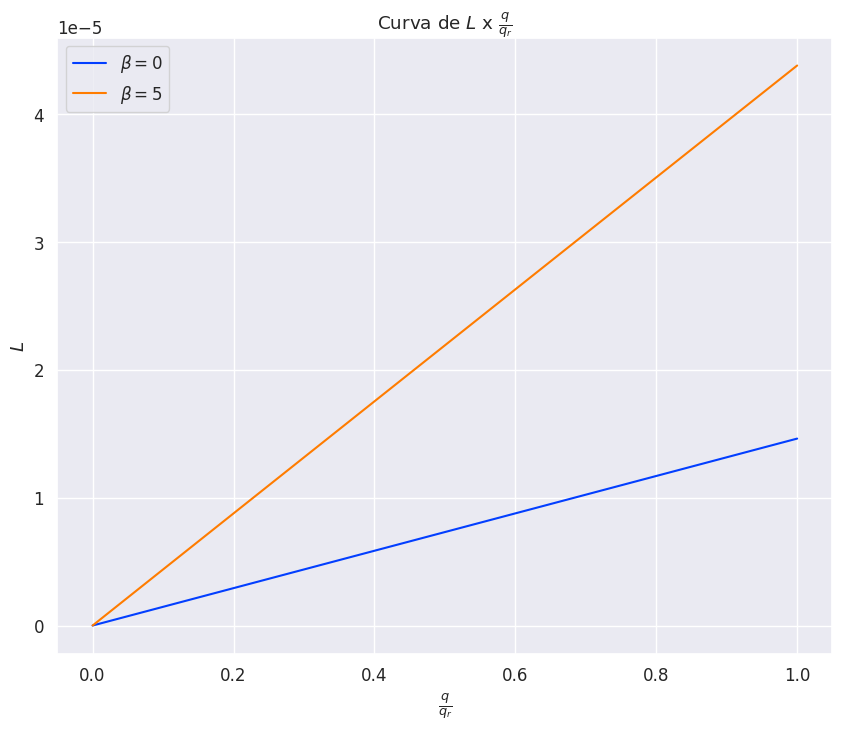

In [ ]:
#@title #Questão 08

q   = sp.Symbol("q", positive = True)
S   = sp.Symbol("S", positive = True)
c   = sp.Symbol("c", positive = True)
e   = sp.Symbol("e", positive = True)
a0  = sp.Symbol("a_0", positive = True)
b  = sp.Symbol("\\beta", positive = True)

CL0 = sp.Symbol("C_{L_0}")
CLa = sp.Symbol("C_{L_\\alpha}")
CLb = sp.Symbol("C_{L_\\beta}")
CM0 = sp.Symbol("C_{M_0}")
CMb = sp.Symbol("C_{M_\\beta}")

kt    = sp.Symbol("k_\\theta", positive = True)
qr    = sp.Symbol("q_r", positive = True)
qd    = sp.Symbol("q_d", positive = True)
theta = sp.Symbol("\\theta"  , positive = True)

L = q * S * (CL0 + CLa * (a0 + theta) + CLb * b)
M = q * S * c * (CM0 + CMb * b)

exp1 = L * e + M - kt * theta
exp2 = sp.solve(exp1, theta)[0]

display(Markdown("### Do Equilibrio de momentos"))
display(sp.Eq(theta, exp2))

# sp.solve(exp1, theta)[0]
display(Markdown("###Substituindo theta no L"))
L_value = L.subs(theta, exp2)
display(sp.Eq(L, L_value))

display(Markdown("###Derivando L em relação a beta e igualando a 0"))
dLdb = sp.diff(L_value, b)
display(sp.Eq(dLdb, 0))

display(Markdown("###q de reversão de comando"))
qr_value = sp.solve(sp.Eq(dLdb, 0), q)[0]
display(sp.Eq(qr, qr_value))

vars = {
    CL0 : np.deg2rad(2),
    CLa : 2 * sp.pi,
    CLb : 0.8,
    CM0 : 0,
    CMb : -2,
    e   : 0.05,
    S   : c,
    c   : 0.20,
    kt  : 300,
    a0  : 0
}

display(Markdown("###substituindo os valores"))
display(sp.Eq(qr, qr_value.subs(vars).evalf()))
print()

Lb = (L_value.subs(vars) / qr_value.subs(vars))

Lb0 = Lb.subs(b, np.deg2rad(0))
Lb5 = Lb.subs(b, np.deg2rad(5))

fLb0 = sp.lambdify(q, Lb0)
fLb5 = sp.lambdify(q, Lb5)

q_range = np.linspace(0, 1, 100)

plt.title("Curva de $L$ x $\\frac{q}{q_r}$")
plt.plot(q_range, fLb0(q_range), label = "$\\beta = 0$")
plt.plot(q_range, fLb5(q_range), label = "$\\beta = 5$")
plt.xlabel("$\\frac{q}{q_r}$")
plt.ylabel("$L$")

_ = plt.legend()

In [ ]:
#@title #Questão 09 { form-width: "20px" }

#@markdown acho que está questão esta repetida com a 11

#@markdown A asa é modelada como uma viga em balanço com rigidez torsional GJ
W = sp.Symbol("W", positive = True)

xca = sp.Symbol("x_{ca}", positive = True)
xcg = sp.Symbol("x_{cg}", positive = True)
x0  = sp.Symbol("x_{0}", positive = True)
y   = sp.Symbol("y", positive = True)

c  = sp.Symbol("c", positive = True)
L  = sp.Symbol("L", positive = True)
e  = sp.Symbol("e", positive = True)
e0 = sp.Symbol("e_0", positive = True)
S  = sp.Symbol("S", positive = True)

CMca = sp.Symbol("C_{M_{ca}}", positive = True)
CL0  = sp.Symbol("C_{L_{0}}", positive = True)
CLa  = sp.Symbol("C_{L_{\\alpha}}", positive = True)
a0   = sp.Symbol("\\alpha_0", positive = True)

q   = sp.Symbol("q", positive = True)
rho = sp.Symbol("\\rho", positive = True)
U   = sp.Symbol("U", positive = True)

GJ  = sp.Symbol("GJ", positive = True)
kt  = sp.Symbol("kt", positive = True)
theta = sp.Function("\\theta", positive = True)

B = sp.Symbol("B", positive = True)
A = sp.Symbol("A", positive = True)
E = sp.Symbol("E", positive = True)

edo = sp.diff(theta(y), y, y) + q * c * e * CLa / GJ * theta(y) + 1/GJ * (q * c **2 * CMca + q * c * e * CL0 + q * c * e * CLa * a0)

display(Markdown("### Da equação do momento"))

display(sp.Eq(edo, 0))

result = sp.dsolve(
    edo,
    ics = {theta(0): 0,
           theta(y).diff(y).subs(y,1): 0}
)

print()
display(Markdown("### Resolvendo a EDO"))
display(sp.Eq(theta(y), sp.factor(result.rhs.trigsimp())))

### Da equação do momento

Eq(C_{L_{\alpha}}*c*e*q*\theta(y)/GJ + Derivative(\theta(y), (y, 2)) + (C_{L_{0}}*c*e*q + C_{L_{\alpha}}*\alpha_0*c*e*q + C_{M_{ca}}*c**2*q)/GJ, 0)

### Resolvendo a EDO

Eq(\theta(y), (C_{L_{0}}*e + C_{L_{\alpha}}*\alpha_0*e + C_{M_{ca}}*c)*(sin(sqrt(C_{L_{\alpha}})*sqrt(c)*sqrt(e)*sqrt(q)*y/sqrt(GJ))*tan(sqrt(C_{L_{\alpha}})*sqrt(c)*sqrt(e)*sqrt(q)/sqrt(GJ)) + cos(sqrt(C_{L_{\alpha}})*sqrt(c)*sqrt(e)*sqrt(q)*y/sqrt(GJ)) - 1)/(C_{L_{\alpha}}*e))

In [12]:
#@title #Questão 10 { form-width: "20px" }

#@markdown A asa é modelada como uma viga em balanço com rigidez torsional GJ
b2 = 0.9
Q_VALUE = 146.6

W = sp.Symbol("W", positive = True)

xca = sp.Symbol("x_{ca}", positive = True)
xcg = sp.Symbol("x_{cg}", positive = True)
x0  = sp.Symbol("x_{0}", positive = True)
y   = sp.Symbol("y", positive = True)

c  = sp.Symbol("c", positive = True)
L  = sp.Symbol("L", positive = True)
e  = sp.Symbol("e", positive = True)
e0 = sp.Symbol("e_0", positive = True)
S  = sp.Symbol("S", positive = True)

CMca = sp.Symbol("C_{M_{ca}}", positive = True)
CL0  = sp.Symbol("C_{L_{0}}", positive = True)
CLa  = sp.Symbol("C_{L_{\\alpha}}", positive = True)
a0   = sp.Symbol("\\alpha_0", positive = True)

q   = sp.Symbol("q", positive = True)
rho = sp.Symbol("\\rho", positive = True)
U   = sp.Symbol("U", positive = True)

GJ  = sp.Symbol("GJ", positive = True)
kt  = sp.Symbol("kt", positive = True)
theta = sp.Function("\\theta", positive = True)

B = sp.Symbol("B", positive = True)
A = sp.Symbol("A", positive = True)
E = sp.Symbol("E", positive = True)

edo = sp.diff(theta(y), y, y) + q * c * e * CLa / GJ * theta(y) + 1/GJ * (q * c **2 * CMca + q * c * e * CL0 + q * c * e * CLa * a0)

display(Markdown("### Da equação do momento"))

display(sp.Eq(edo, 0))

result = sp.dsolve(
    edo,
    ics = {theta(0): 0,
           theta(y).diff(y).subs(y,b2): 0}
)

print()
display(Markdown("### Resolvendo a EDO"))
exp1 = sp.factor(result.rhs.trigsimp())
display(sp.Eq(theta(y), exp1))

vars = {
    GJ: 20,
    e: 1/4 * 0.15,
    c: 0.15,
    e0: 0,
    CL0: 0,
    CLa: 2 * sp.pi,
    CMca: 0,
    a0: np.deg2rad(2),
}

exp2 = b2 * sp.sqrt(CLa * c * e * q / GJ)

q_div = (sp.solve(exp2 - sp.pi/2, q)[0]).subs(vars).evalf()

sealevel = Atmosphere(0)
U_value = (2 * q_div / float(sealevel.density)) ** 0.5

print()
display(Latex(f"\\qquad a) \quad q_d = {q_div:.3f} Pa, \quad {U} = {U_value:.3f} m/s"))

new_GJ = (sp.solve(exp2 - sp.pi/2, GJ)[0]).subs(vars).subs(q, 2 * q_div).evalf()
newGJ = "GJ_{new}"
display(Latex(f"\\qquad b) \quad {newGJ} = {new_GJ:.3f} N/m"))

new_e = (sp.solve(exp2 - sp.pi/2, e)[0]).subs(vars).subs(q, 2 * q_div).evalf()
newe = "e_{new}"
display(Latex(f"\\qquad c) \quad {newe} = {new_e:.3f} m"))

delta_CL = (CLa * exp1 / (CL0 + CLa * (a0 + exp1))).subs(vars).subs(q, Q_VALUE).subs(y, 0.9/2).evalf()
deltaCL = "\\Delta C_L"
display(Latex(f"\\qquad d) \quad {deltaCL} = {delta_CL:.3f} "))

CLy = sp.lambdify(y, (CLa * exp1 / (CL0 + CLa * (a0 + exp1))).subs(vars).subs(q, Q_VALUE))

y_range = np.linspace(0, b2, 100)
dy = y_range[1] - y_range[0]
delta_CL_total = (CLy(y_range) * dy).sum()
deltaCLtotal = "\\Delta C_{L_{total}}"

display(Latex(f"\\qquad d) \quad {deltaCLtotal} = {delta_CL_total:.3f} "))


### Da equação do momento

Eq(C_{L_{\alpha}}*c*e*q*\theta(y)/GJ + Derivative(\theta(y), (y, 2)) + (C_{L_{0}}*c*e*q + C_{L_{\alpha}}*\alpha_0*c*e*q + C_{M_{ca}}*c**2*q)/GJ, 0)

### Resolvendo a EDO

Eq(\theta(y), (C_{L_{0}}*e + C_{L_{\alpha}}*\alpha_0*e + C_{M_{ca}}*c)*(sin(sqrt(C_{L_{\alpha}})*sqrt(c)*sqrt(e)*sqrt(q)*y/sqrt(GJ))*tan(0.9*sqrt(C_{L_{\alpha}})*sqrt(c)*sqrt(e)*sqrt(q)/sqrt(GJ)) + cos(sqrt(C_{L_{\alpha}})*sqrt(c)*sqrt(e)*sqrt(q)*y/sqrt(GJ)) - 1)/(C_{L_{\alpha}}*e))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#Questão 11

a asa é modelada como uma viga em balanço com flexão pura

como o ângulo de ataque não muda, pode-se considerar um carregamento uniforme sobre a barra

<img src="https://drive.google.com/uc?export=download&id=1PMUYrJVj34zSDxr7b1kxYDEeKvikohxu&confirm=no_antivirus" alt= “” width="500" height="value">

Na verdade não entendi muito bem oq ta acontecendo, parece q a flexão pura ta modelando um diedro na asa, mas o diedro diminuiria a força na direção vertical $F = L \cos{\Gamma}$


In [42]:
#@title #Questão 12

M01 = sp.Symbol("M_{0,1}")
M02 = sp.Symbol("M_{0,2}")
M03 = sp.Symbol("M_{0,3}")

k1 = sp.Symbol("k_1")
k2 = sp.Symbol("k_2")
k3 = sp.Symbol("k_3")

t1 = sp.Symbol("\\theta_1")
t2 = sp.Symbol("\\theta_2")
t3 = sp.Symbol("\\theta_3")

q = sp.Symbol("q", positive = True)
e = sp.Symbol("e", positive = True)
CLa = sp.Symbol("C_{L_a}")
CL0 = sp.Symbol("C_{L_0}")
CMca = sp.Symbol("C_{M_{ca}}")
a0 = sp.Symbol("\\alpha_0")

display(sp.Eq(q * c * e * (CL0 + CLa * (a0 + t1)), k1 * t1 - k2 * (t2-t1)))
display(sp.Eq(q * c * e * (CL0 + CLa * (a0 + t2)), k2 * (t2-t1) - k3 * (t3-t2)))
display(sp.Eq(q * c * e * (CL0 + CLa * (a0 + t3)), k3 * (t3-t2)))

one_vec = sp.Matrix([[1] , [1] , [1 ]])
theta   = sp.Matrix([[t1], [t2], [t3]])

K = sp.Matrix([[ k1+k2, -k2      , 0  ],
               [-k2   ,  k2 + k3 , -k3],
               [0     , -k3      , k3 ]])

display(Markdown("### Matrix de rigidez"))
display(K)
A = q * c * e * CLa * sp.Matrix(sp.eye(3))
f = q * c * (e * (CL0 + CLa * a0) + c * CMca) * one_vec

theta_value = (K - A).inv() @ f

display(Markdown("### Resolvendo para theta"))
display(sp.Eq(theta, theta_value))
display(Markdown("### Polinomio Caracteristico"))
display(sp.Eq((K-A).det(), 0))

Eq(c*e*q*(C_{L_0} + C_{L_a}*(\alpha_0 + \theta_1)), \theta_1*k_1 - k_2*(-\theta_1 + \theta_2))

Eq(c*e*q*(C_{L_0} + C_{L_a}*(\alpha_0 + \theta_2)), k_2*(-\theta_1 + \theta_2) - k_3*(-\theta_2 + \theta_3))

Eq(c*e*q*(C_{L_0} + C_{L_a}*(\alpha_0 + \theta_3)), k_3*(-\theta_2 + \theta_3))

### Matrix de rigidez

Matrix([
[k_1 + k_2,      -k_2,    0],
[     -k_2, k_2 + k_3, -k_3],
[        0,      -k_3,  k_3]])

### Resolvendo para theta

Eq(Matrix([
[\theta_1],
[\theta_2],
[\theta_3]]), Matrix([
[                                                           -c*k_2*k_3*q*(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))/(C_{L_a}**3*c**3*e**3*q**3 - C_{L_a}**2*c**2*e**2*k_1*q**2 - 2*C_{L_a}**2*c**2*e**2*k_2*q**2 - 2*C_{L_a}**2*c**2*e**2*k_3*q**2 + C_{L_a}*c*e*k_1*k_2*q + 2*C_{L_a}*c*e*k_1*k_3*q + 3*C_{L_a}*c*e*k_2*k_3*q - k_1*k_2*k_3) + c*q*(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))*(C_{L_a}*c*e*k_2*q - k_2*k_3)/(C_{L_a}**3*c**3*e**3*q**3 - C_{L_a}**2*c**2*e**2*k_1*q**2 - 2*C_{L_a}**2*c**2*e**2*k_2*q**2 - 2*C_{L_a}**2*c**2*e**2*k_3*q**2 + C_{L_a}*c*e*k_1*k_2*q + 2*C_{L_a}*c*e*k_1*k_3*q + 3*C_{L_a}*c*e*k_2*k_3*q - k_1*k_2*k_3) + c*q*(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))*(-C_{L_a}**2*c**2*e**2*q**2 + C_{L_a}*c*e*k_2*q + 2*C_{L_a}*c*e*k_3*q - k_2*k_3)/(C_{L_a}**3*c**3*e**3*q**3 - C_{L_a}**2*c**2*e**2*k_1*q**2 - 2*C_{L_a}**2*c**2*e**2*k_2*q**2 - 2*C_{L_a}**2*c**2*e**2*k_3*q**2 + C_{L_a}*c*e*k_1*k_2*q + 2*C_{L_a}*c*

### Polinomio Caracteristico

Eq(-C_{L_a}**3*c**3*e**3*q**3 + C_{L_a}**2*c**2*e**2*k_1*q**2 + 2*C_{L_a}**2*c**2*e**2*k_2*q**2 + 2*C_{L_a}**2*c**2*e**2*k_3*q**2 - C_{L_a}*c*e*k_1*k_2*q - 2*C_{L_a}*c*e*k_1*k_3*q - 3*C_{L_a}*c*e*k_2*k_3*q + k_1*k_2*k_3, 0)

In [53]:
#@title #Questão 13

M01 = sp.Symbol("M_{0,1}")
M02 = sp.Symbol("M_{0,2}")
M03 = sp.Symbol("M_{0,3}")

k1 = sp.Symbol("k_1")
k2 = sp.Symbol("k_2")
k3 = sp.Symbol("k_3")

t1 = sp.Symbol("\\theta_1")
t2 = sp.Symbol("\\theta_2")
t3 = sp.Symbol("\\theta_3")

x1 = sp.Symbol("x_1")
x2 = sp.Symbol("x_2")
x3 = sp.Symbol("x_3")

q = sp.Symbol("q", positive = True)
e = sp.Symbol("e", positive = True)
CLa = sp.Symbol("C_{L_a}")
CL0 = sp.Symbol("C_{L_0}")
CMca = sp.Symbol("C_{M_{ca}}")
a0 = sp.Symbol("\\alpha_0")

display(Markdown("#i)"))
one_vec = sp.Matrix([[1] , [1] , [1 ]])
theta   = sp.Matrix([[t1], [t2], [t3]])

K = sp.Matrix([[ k1+k2, -k2      , 0  ],
               [-k2   ,  k2 + k3 , -k3],
               [0     , -k3      , k3 ]])
K = K.subs({k1: 0, k2: 0, k3: 0})
display(Markdown("### Matrix de rigidez"))
display(K)
A = q * c * e * CLa * sp.Matrix(sp.eye(3))
f = q * c * (e * (CL0 + CLa * a0) + c * CMca) * one_vec

theta_value = (K - A).inv() @ f

display(Markdown("### Resolvendo para theta"))
display(sp.Eq(theta, theta_value))
display(Markdown("### Polinomio Caracteristico"))
display(sp.Eq((K-A).det(), 0))

display(Markdown("#ii)"))
one_vec = sp.Matrix([[1] , [1] ])
theta   = sp.Matrix([[t1], [t2]])

K = sp.Matrix([[ k1+k2, -k2],
               [-k2   ,  k2]])

display(Markdown("### Matrix de rigidez"))
display(K)
A = q * c * e * CLa * sp.Matrix(sp.eye(2))
f = q * c * (e * (CL0 + CLa * a0) + c * CMca) * one_vec

theta_value = (K - A).inv() @ f

display(Markdown("### Resolvendo para theta"))
display(sp.Eq(theta, theta_value))
display(Markdown("### Polinomio Caracteristico"))
display(sp.Eq((K-A).det(), 0))

display(Markdown("#iii)"))
display(sp.Eq(q * c * (CL0 + CLa * (a0)), k1 * x1 - k2 * (x2-x1)))
display(sp.Eq(q * c * (CL0 + CLa * (a0)), k2 * (x2-x1) - k3 * (x3-x2)))
display(sp.Eq(q * c * (CL0 + CLa * (a0)), k3 * (x3-x2)))

K = sp.Matrix([[ k1+k2, -k2      , 0  ],
               [-k2   ,  k2 + k3 , -k3],
               [0     , -k3      , k3 ]])


x       = sp.Matrix([[x1], [x2], [x3]])
one_vec = sp.Matrix([[1] , [1] , [1 ]])
f = q * c * ((CL0 + CLa * a0)) * one_vec

x_value = (K).inv() @ f

display(Markdown("### Resolvendo para x"))
display(sp.Eq(x, x_value))

display(Markdown("### Polinomio Caracteristico"))
display(sp.Eq((K).det(), 0))

#i)

### Matrix de rigidez

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

### Resolvendo para theta

Eq(Matrix([
[\theta_1],
[\theta_2],
[\theta_3]]), Matrix([
[-(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))/(C_{L_a}*e)],
[-(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))/(C_{L_a}*e)],
[-(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))/(C_{L_a}*e)]]))

### Polinomio Caracteristico

Eq(-C_{L_a}**3*c**3*e**3*q**3, 0)

#ii)

### Matrix de rigidez

Matrix([
[k_1 + k_2, -k_2],
[     -k_2,  k_2]])

### Resolvendo para theta

Eq(Matrix([
[\theta_1],
[\theta_2]]), Matrix([
[      c*k_2*q*(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))/(C_{L_a}**2*c**2*e**2*q**2 - C_{L_a}*c*e*k_1*q - 2*C_{L_a}*c*e*k_2*q + k_1*k_2) + c*q*(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))*(-C_{L_a}*c*e*q + k_2)/(C_{L_a}**2*c**2*e**2*q**2 - C_{L_a}*c*e*k_1*q - 2*C_{L_a}*c*e*k_2*q + k_1*k_2)],
[c*k_2*q*(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))/(C_{L_a}**2*c**2*e**2*q**2 - C_{L_a}*c*e*k_1*q - 2*C_{L_a}*c*e*k_2*q + k_1*k_2) + c*q*(C_{M_{ca}}*c + e*(C_{L_0} + C_{L_a}*\alpha_0))*(-C_{L_a}*c*e*q + k_1 + k_2)/(C_{L_a}**2*c**2*e**2*q**2 - C_{L_a}*c*e*k_1*q - 2*C_{L_a}*c*e*k_2*q + k_1*k_2)]]))

### Polinomio Caracteristico

Eq(C_{L_a}**2*c**2*e**2*q**2 - C_{L_a}*c*e*k_1*q - 2*C_{L_a}*c*e*k_2*q + k_1*k_2, 0)

#iii)

Eq(c*q*(C_{L_0} + C_{L_a}*\alpha_0), k_1*x_1 - k_2*(-x_1 + x_2))

Eq(c*q*(C_{L_0} + C_{L_a}*\alpha_0), k_2*(-x_1 + x_2) - k_3*(-x_2 + x_3))

Eq(c*q*(C_{L_0} + C_{L_a}*\alpha_0), k_3*(-x_2 + x_3))

### Resolvendo para x

Eq(Matrix([
[x_1],
[x_2],
[x_3]]), Matrix([
[                                                                                                            3*c*q*(C_{L_0} + C_{L_a}*\alpha_0)/k_1],
[                                                   c*q*(C_{L_0} + C_{L_a}*\alpha_0)/k_1 + 2*c*q*(C_{L_0} + C_{L_a}*\alpha_0)*(k_1 + k_2)/(k_1*k_2)],
[c*q*(C_{L_0} + C_{L_a}*\alpha_0)*(1/k_2 + 1/k_1) + c*q*(C_{L_0} + C_{L_a}*\alpha_0)*(1/k_3 + 1/k_2 + 1/k_1) + c*q*(C_{L_0} + C_{L_a}*\alpha_0)/k_1]]))

### Polinomio Caracteristico

Eq(k_1*k_2*k_3, 0)

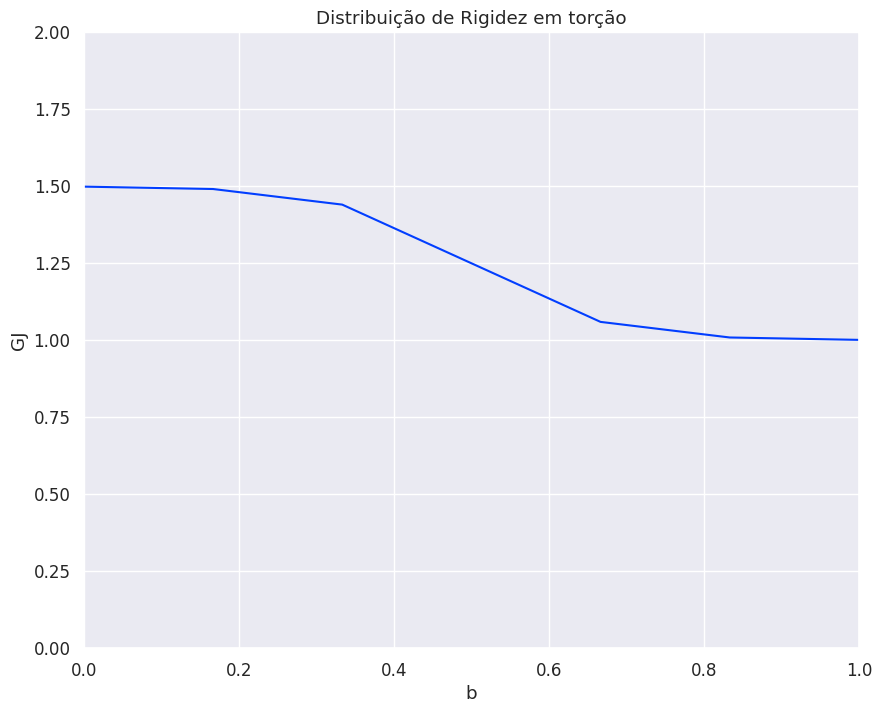

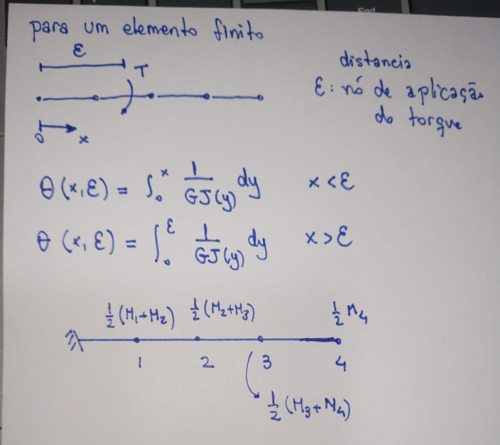

##Matrix de deslocamentos angulares

1/GJ*Matrix([
[                          0.334476075430507*M_{1},                           0.334476075430507*M_{1},                           0.334476075430507*M_{1},                           0.334476075430507*M_{1},                           0.334476075430507*M_{1},                           0.334476075430507*M_{1}],
[0.334476075430507*M_{1} + 0.334476075430507*M_{2}, 0.675711078169383*M_{1} + 0.675711078169383*M_{2}, 0.675711078169383*M_{1} + 0.675711078169383*M_{2}, 0.675711078169383*M_{1} + 0.675711078169383*M_{2}, 0.675711078169383*M_{1} + 0.675711078169383*M_{2}, 0.675711078169383*M_{1} + 0.675711078169383*M_{2}],
[0.334476075430507*M_{2} + 0.334476075430507*M_{3}, 0.675711078169383*M_{2} + 0.675711078169383*M_{3},   1.04927415341069*M_{2} + 1.04927415341069*M_{3},   1.04927415341069*M_{2} + 1.04927415341069*M_{3},   1.04927415341069*M_{2} + 1.04927415341069*M_{3},   1.04927415341069*M_{2} + 1.04927415341069*M_{3}],
[0.334476075430507*M_{3} + 0.334476075430507*M_{4}, 0.67571107

In [76]:
from scipy.sparse import dia_array

#@title #Questão 14 {run: "auto"}
#@markdown numero de nós

n = 6  #@param {type: "slider", min: 2, max: 10}

GJ = sp.Symbol("GJ", positive = True)

def sig(x):
    return 1/(1 + np.exp(-x))


x = np.linspace(-6, 6 , n+1)
y = 1/2 * (1 - sig(x)) + 1
x = (x + 6) / 12
dx = x[1] - x[0]

plt.plot(x, y)
plt.ylim(0, 2)
plt.xlim(0, 1)
plt.ylabel("GJ")
plt.xlabel("b")
plt.title("Distribuição de Rigidez em torção")
plt.show()

url = "https://drive.google.com/uc?export=download&id=18YS9-APzaFlzR605uSDp6Rp5tjiMgJI-&confirm=no_antivirus"

image = Image.open(req.get(url, stream=True).raw)
image.thumbnail((500, 500))
image.show()

nodes = [0]
for i in range(1, n):
    exec(f"M{i} = " + "sp.Symbol('M_{" + str(i) +"}')")
    exec(f"nodes.append(M{i})")

nodes.append(0)
positions = np.linspace(0,1,n+1)

rigid_matrix = sp.Matrix(np.zeros((n, n)))

for i in range(0, n):
    ETA         = positions[i]
    curr_moment = nodes[i] + nodes[i+1]

    for j in range(0, n):
        X = positions[j]

        if X <= ETA:
            value = np.trapz(1 / y[:j+2])
        else:
            value = np.trapz(1 / y[:i+2])

        rigid_matrix[i, j] += curr_moment/2 * value

display(Markdown("##Matrix de deslocamentos angulares"))
display(sp.MatMul(1/GJ, rigid_matrix, evaluate = False))